In [1]:
import os, sys
os.environ["MALLOC_TRIM_THRESHOLD_"] = '0'
import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(16,4))
plt.rc("font", size=14)
ccrs.PlateCarree()

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, protocol = 'tcp')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://127.0.0.1:33029,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://127.0.0.1:38733,Total threads: 4
Dashboard: http://127.0.0.1:40921/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
indir_anom = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/TCWV/'

datasets = []
datasets_T = []
datasets_WB = []

year = np.arange(2012,2017)
for y in year :
    ds = xr.open_mfdataset(indir_anom + '*' + str(y) + '.nc', chunks = {'time' : 1})
    ds_T = xr.open_mfdataset(indir_anom + '*' + str(y) + '*TOUCAN.nc', chunks = {'time' : 1})
    ds_T_WB = xr.open_mfdataset(indir_anom + '*' + str(y) + '*TOUCAN_without_biais.nc', chunks = {'time' : 1})
    ds = ds.sel(latitude = slice(40.1,-40.1))
    ds_T = ds_T.sel(latitude = slice(40.1,-40.1))
    ds_T_WB = ds_T_WB.sel(latitude = slice(40.1,-40.1))
    datasets.append(ds)
    datasets_T.append(ds_T)
    datasets_WB.append(ds_T_WB)

ds = xr.concat(datasets, dim = 'time')
ds_T = xr.concat(datasets_T, dim = 'time')
ds_T_WB = xr.concat(datasets_WB, dim = 'time')


ds = ds.isel(time = slice(0,None,8)).compute()
ds_T = ds_T.isel(time = slice(0,None,8)).compute()
ds_T_WB = ds_T_WB.isel(time = slice(0,None,8)).compute()

In [4]:
ds_std_anom = xr.open_mfdataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/TCWV/MEAN/ds_anom_std_Y.nc')
ds_std_anom_PTOUCAN = xr.open_mfdataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/TCWV/MEAN/ds_anom_std_Y.nc')
ds_std_anom_T = ds_T.std('time')
ds_std_anom_WB = xr.open_mfdataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/TCWV/MEAN/ds_anom_std_Y_TOUCAN.nc')

ds_std_anom = (ds_std_anom['tcwv_ano'].sel(latitude = slice(40.1,-40.1)).load())
ds_std_anom_PTOUCAN = (ds_std_anom_PTOUCAN['tcwv_ano'].sel(latitude = slice(40.1,-40.1)).load())
ds_std_anom_T = (ds_std_anom_T['tcwv_ano'].sel(latitude = slice(40.1,-40.1)).load())
ds_std_anom_WB = (ds_std_anom_WB['tcwv_ano'].sel(latitude = slice(40.1,-40.1)).load())



In [ ]:
# ### Construction of the gaussienne curve
# ds_mean = xr.open_mfdataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/TCWV/MEAN/mean_anomaly_tcwv_ERA5_3H_2012_2016.nc')
# ds_mean = ds_mean.mean()

# nbPoint = np.linspace(-30,30,101)
# exposant = - (nbPoint - ds_mean)**2 / 2*(ds_std_anom_PTOUCAN)**2
# CurveG = 1/np.sqrt(2*np.pi) * np.exp(exposant)

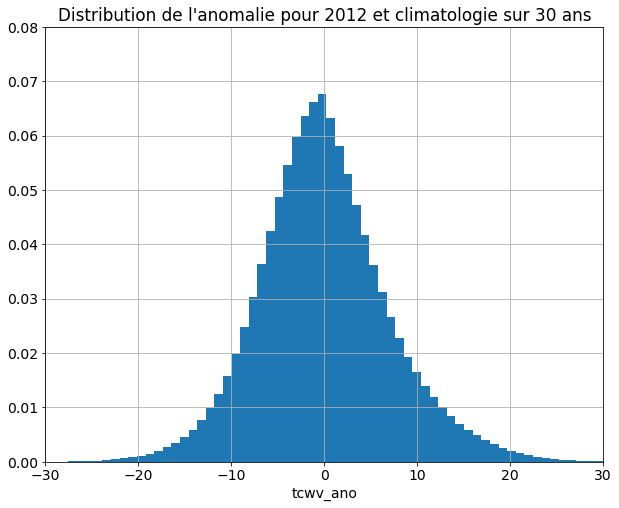

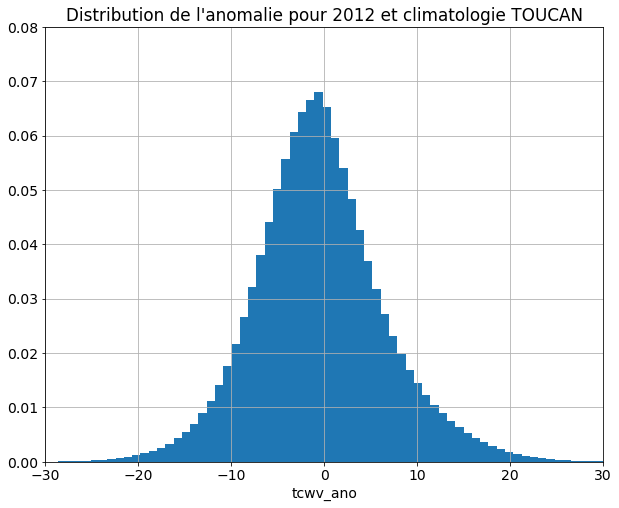

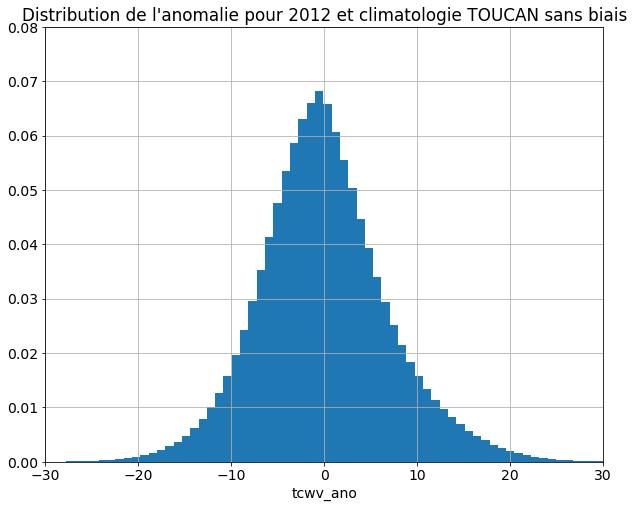

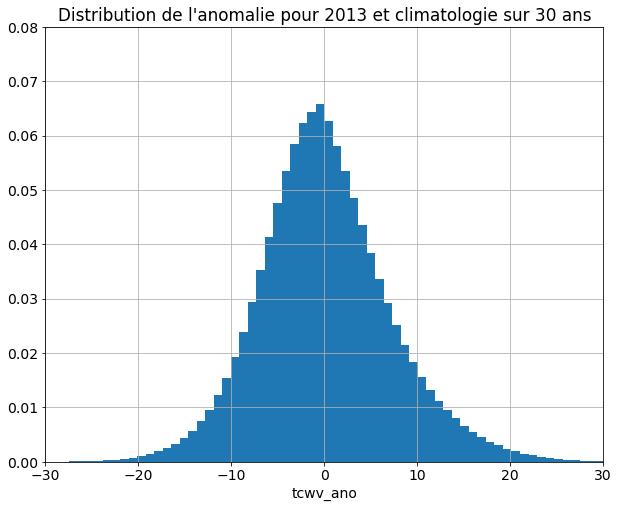

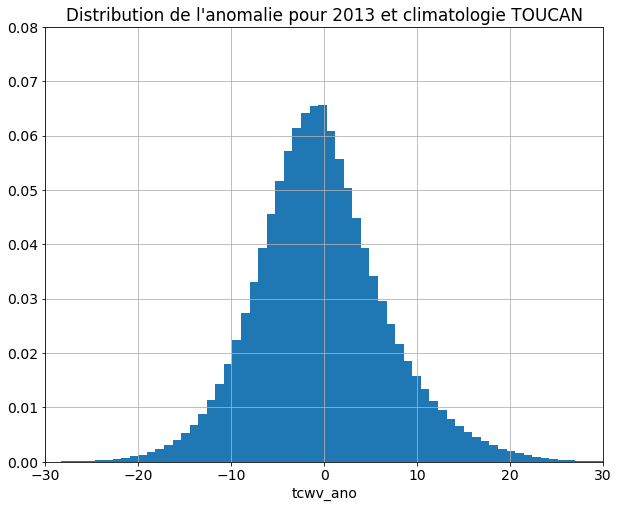

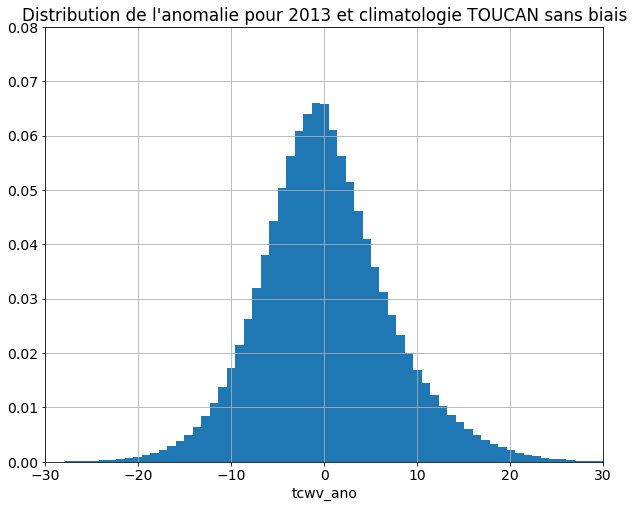

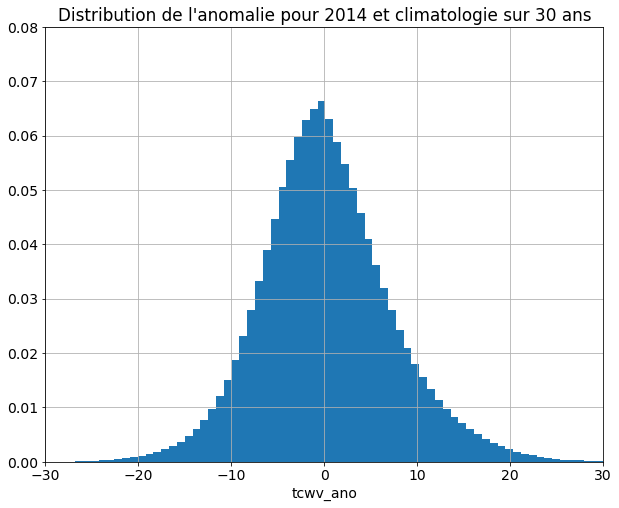

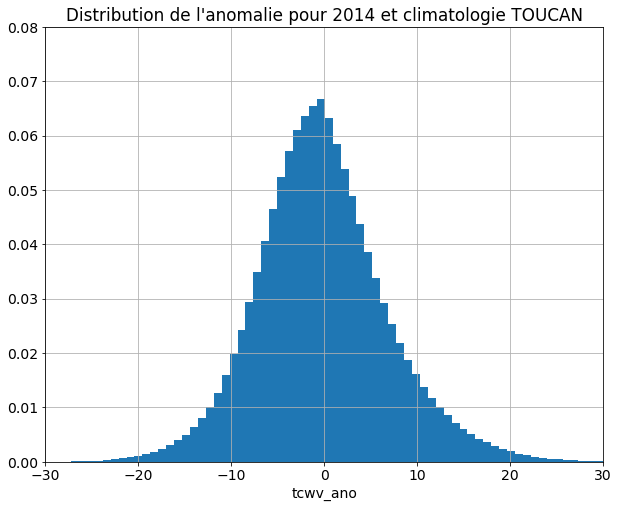

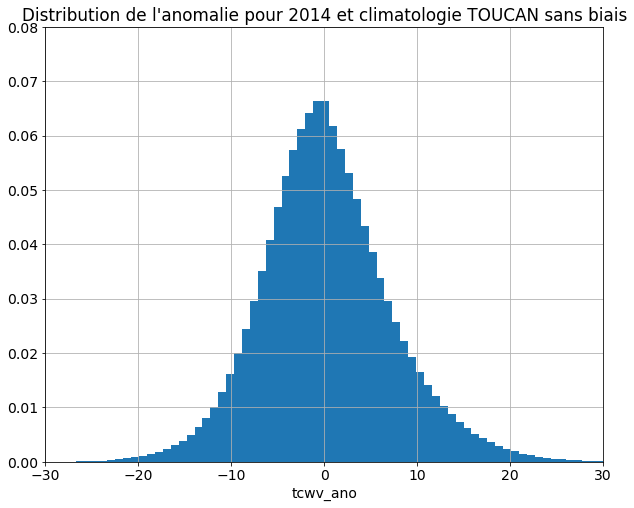

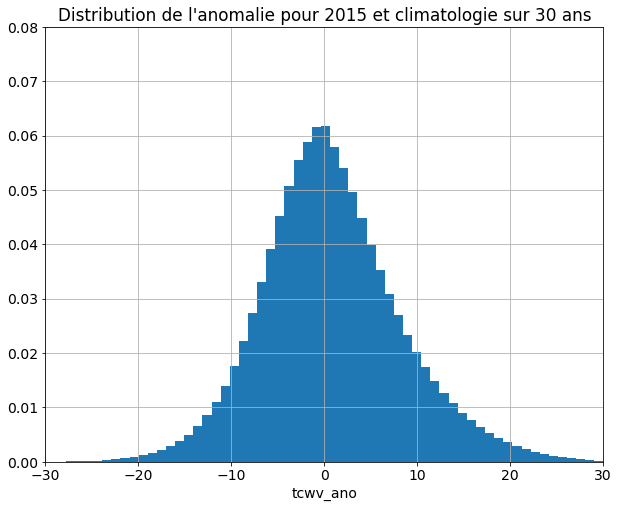

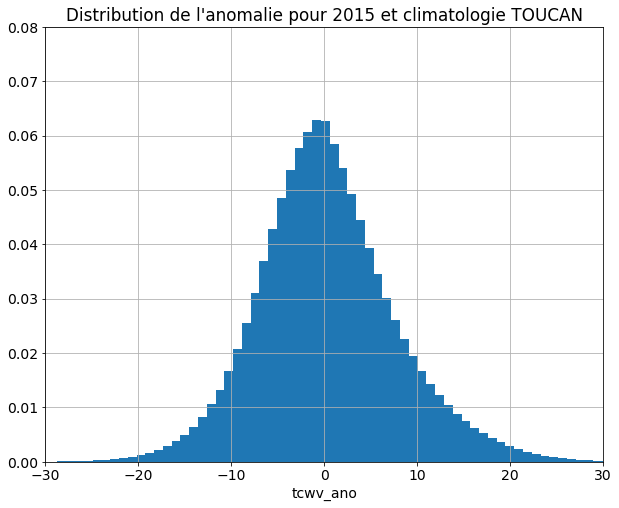

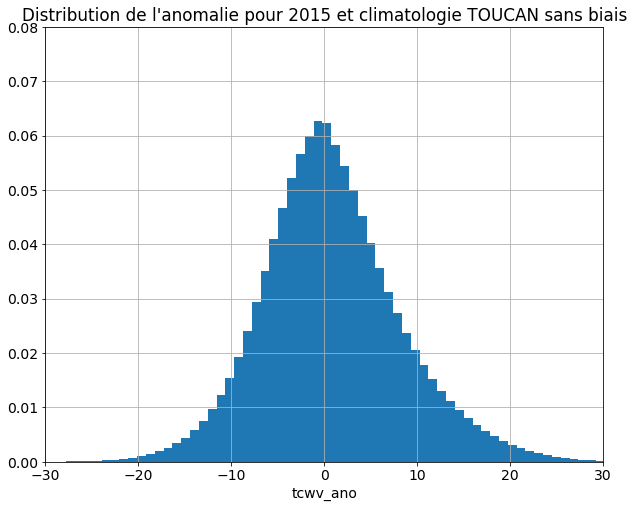

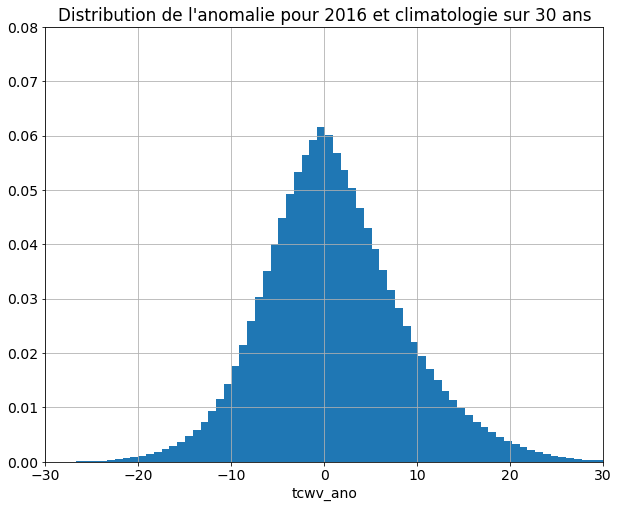

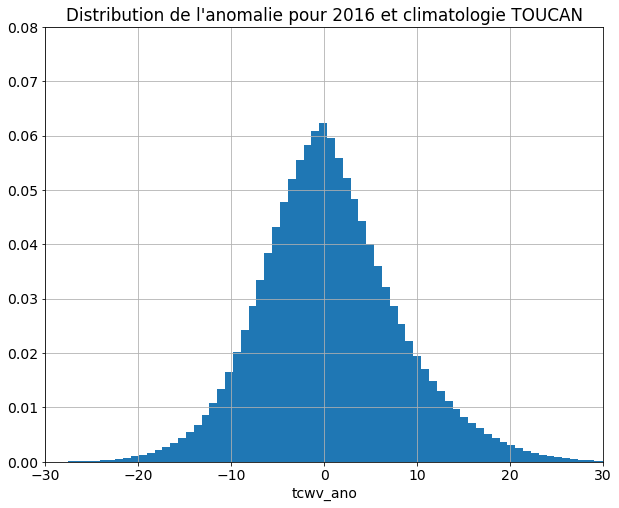

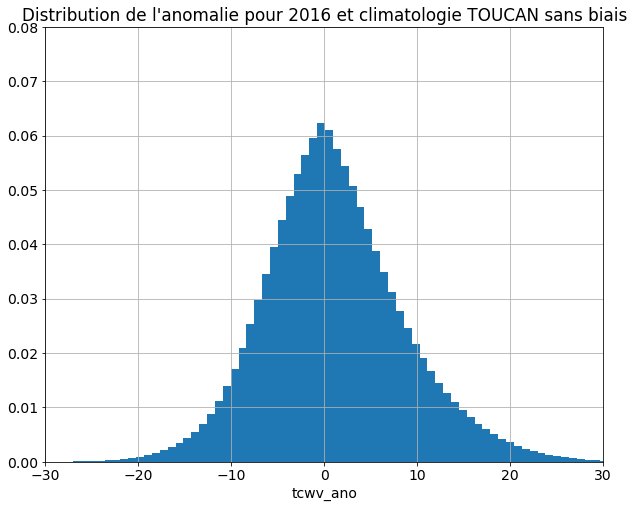

In [3]:
plt.rc("figure", figsize=(10,8))

for y in year :
    da = ds['tcwv_ano'].sel(time = str(y)).load()
    da_T = ds_T['tcwv_ano'].sel(time = str(y)).load()
    da_T_WB = ds_T_WB['tcwv_ano'].sel(time = str(y)).load()

    plt.figure()
    da.plot.hist(bins=101, density = True, xlim = [-30,30], ylim = [0,0.08])
    titre = "Distribution de l'anomalie pour " + str(y) + " et climatologie sur 30 ans"
    plt.title(titre)
    plt.grid()
    plt.show()
    
    plt.figure()
    da_T.plot.hist(bins=101, density = True, xlim = [-30,30], ylim = [0,0.08])
    titre = "Distribution de l'anomalie pour " + str(y) + " et climatologie TOUCAN"
    plt.title(titre)
    plt.grid()
    plt.show()
    
    plt.figure()
    da_T_WB.plot.hist(bins=101, density = True, xlim = [-30,30], ylim = [0,0.08])
    titre = "Distribution de l'anomalie pour " + str(y) + " et climatologie TOUCAN sans biais"
    plt.title(titre)
    plt.grid()
    plt.show()

In [5]:
nRange = np.arange(0, 2, 1, dtype='int')

distri = ds_std_anom*0.
distri = distri.expand_dims(nRange = nRange)
distri = distri.copy()

distri_PTOUCAN = ds_std_anom_PTOUCAN*0.
distri_PTOUCAN = distri_PTOUCAN.expand_dims(nRange = nRange)
distri_PTOUCAN = distri_PTOUCAN.copy()

distri_T = ds_std_anom_T*0.
distri_T = distri_T.expand_dims(nRange = nRange)
distri_T = distri_T.copy()

distri_T_WB = ds_std_anom_WB*0.
distri_T_WB = distri_T_WB.expand_dims(nRange = nRange)
distri_T_WB = distri_T_WB.copy()


for t in range(ds.time.size) :
#     print(t)
    __da = ds.isel(time = t)
    __da_T = ds_T.isel(time = t)
    __da_T_WB = ds_T_WB.isel(time = t)
    
    __da = __da['tcwv_ano']
    __da_T = __da_T['tcwv_ano']
    __da_T_WB = __da_T_WB['tcwv_ano']

    distri[0] = xr.where( (__da <= -ds_std_anom) == True , distri[0] + 1, distri[0])
    distri[1] = xr.where( ((__da < ds_std_anom) & (__da > -ds_std_anom)) == True , distri[1] + 1, distri[1])
    distri[0] = xr.where( (__da >= ds_std_anom) == True , distri[0] + 1, distri[0])
    
    distri_PTOUCAN[0] = xr.where( (__da <= -ds_std_anom_PTOUCAN) == True , distri_PTOUCAN[0] + 1, distri_PTOUCAN[0])
    distri_PTOUCAN[1] = xr.where( ((__da < ds_std_anom_PTOUCAN) & (__da > -ds_std_anom_PTOUCAN)) == True , distri_PTOUCAN[1] + 1, distri_PTOUCAN[1])
    distri_PTOUCAN[0] = xr.where( (__da >= ds_std_anom_PTOUCAN) == True , distri_PTOUCAN[0] + 1, distri_PTOUCAN[0])

    distri_T[0] = xr.where( (__da_T <= -ds_std_anom_T) == True , distri_T[0] + 1, distri_T[0])
    distri_T[1] = xr.where( ((__da_T < ds_std_anom_T) & (__da_T > -ds_std_anom_T)) == True , distri_T[1] + 1, distri_T[1])
    distri_T[0] = xr.where( (__da_T >= ds_std_anom_T) == True , distri_T[0] + 1, distri_T[0])
    
    distri_T_WB[0] = xr.where( (__da_T_WB <= -ds_std_anom_WB) == True , distri_T_WB[0] + 1, distri_T_WB[0])
    distri_T_WB[1] = xr.where( ((__da_T_WB < ds_std_anom_WB) & (__da_T_WB > -ds_std_anom_WB)) == True , distri_T_WB[1] + 1, distri_T_WB[1])
    distri_T_WB[0] = xr.where( (__da_T_WB >= ds_std_anom_WB) == True , distri_T_WB[0] + 1, distri_T_WB[0])

# Ecart - type pour les différentes climatologie sur la période TOUCAN

## Calcul de la variance pour l'anomalie
\begin{equation}
\sigma^2_j = \frac{\displaystyle\sum_{i=1}^{n_j}(x_i - \mu_i)^2} {n_j} \\
\text{$j$ de 1 à 12 ou de 1 à 4, $\mu_i$ la moyenne au pas de temps, n le nombre de pas de temps $n_j = nbAnnee * nbJour_j * \frac{24}{3}$}
\end{equation}


In [8]:
#### Parameter for plotting
plt.rc("figure", figsize=(18,5))

vmax = 12
vmin = 0
levels = 13
cmap ='RdBu_r'
size = 5

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-40.0, 
                         max_latitude=40.0, 
                         globe=None)

colorbar = {'label': 'std',
            'orientation': 'vertical' , 'ticks': np.arange(vmin,vmax+.1,2),
            'extend' : 'both'}


# Pour 30 ans

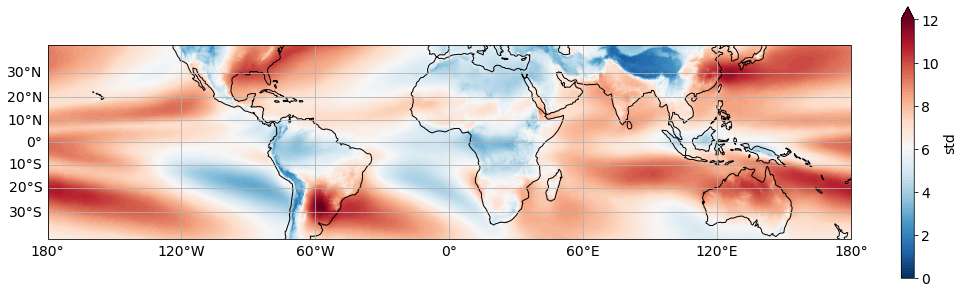

In [8]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_std_anom.plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree(),
                    vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# plt.savefig(output_fig+'atlas_varYear_anomaly_TOUCAN.png')

# Pour TOUCAN avec la climatologie sur 30 ans

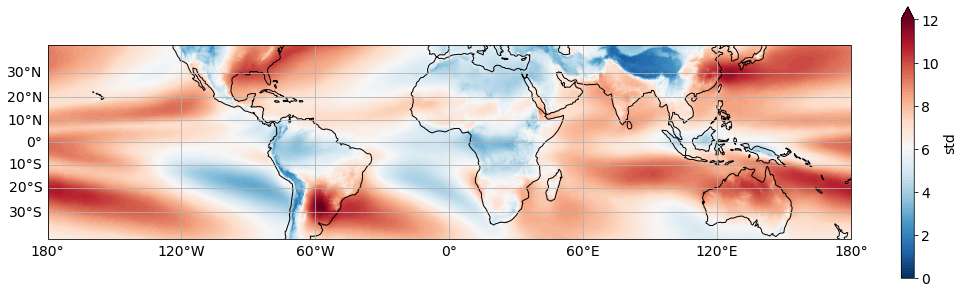

In [9]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_std_anom_PTOUCAN.plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree(),
                    vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# plt.savefig(output_fig+'atlas_varYear_anomaly_TOUCAN.png')

# Pour TOUCAN avec biais

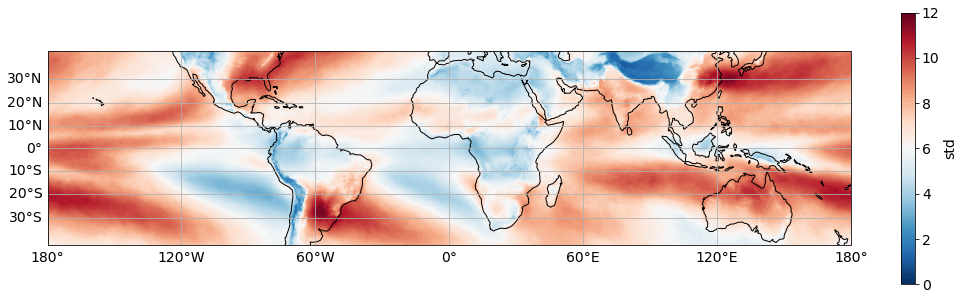

In [10]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_std_anom_T.plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree(),
                    vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# plt.savefig(output_fig+'atlas_varYear_anomaly_TOUCAN.png')

# Pour TOUCAN sans biais

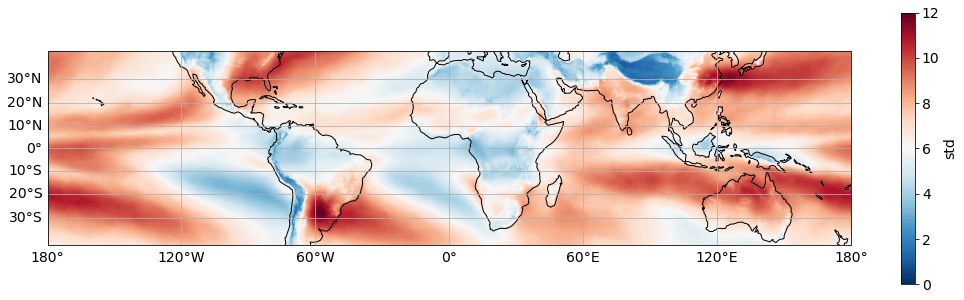

In [11]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_std_anom_WB.plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree(),
                    vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# plt.savefig(output_fig+'atlas_varYear_anomaly_TOUCAN.png')

# Nombre de jours entre 2012 et 2016 (total = 365 * 4), supérieur ou inférieur à l'écart-type

In [7]:
vmax = 900
vmin = 300
levels = 13
cmap ='RdBu_r'
size = 5

colorbar = {'label': 'day over std',
            'orientation': 'vertical' , 'ticks': np.arange(vmin,vmax+.1,50),
            'extend' : 'both'}

# Avec la climatologie sur 30 ans et ecart-type sur 30 ans

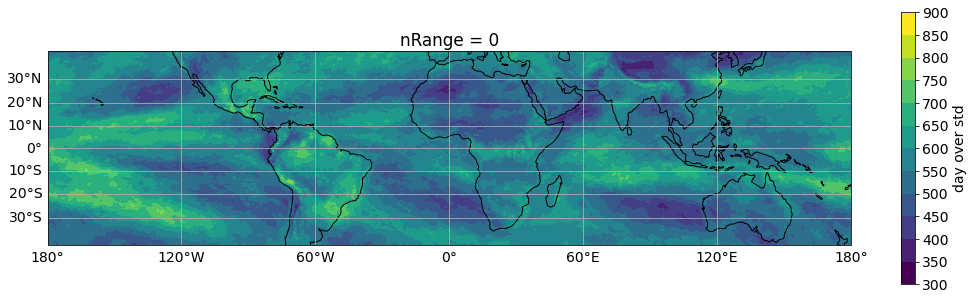

In [13]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

cs = distri[0].plot.contourf(transform=ccrs.PlateCarree(),
                             vmin = vmin, vmax = vmax, levels = levels,
                             cbar_kwargs=colorbar
                            )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

# Avec la climatologie sur 30 ans et ecart-type sur TOUCAN

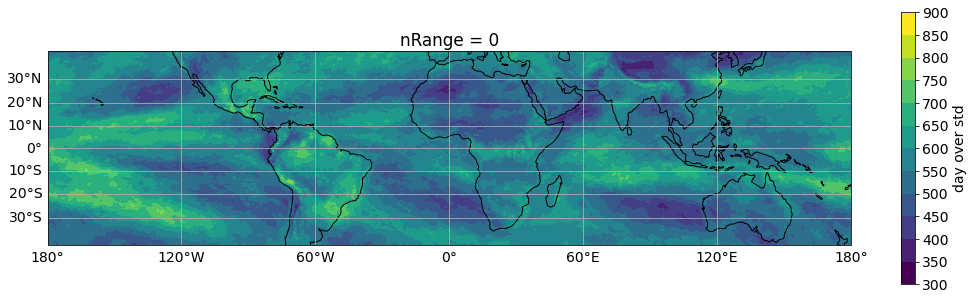

In [14]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

cs = distri_PTOUCAN[0].plot.contourf(transform=ccrs.PlateCarree(),
                             vmin = vmin, vmax = vmax, levels = levels,
                             cbar_kwargs=colorbar
                            )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

# Avec la climatologie sur TOUCAN et biais

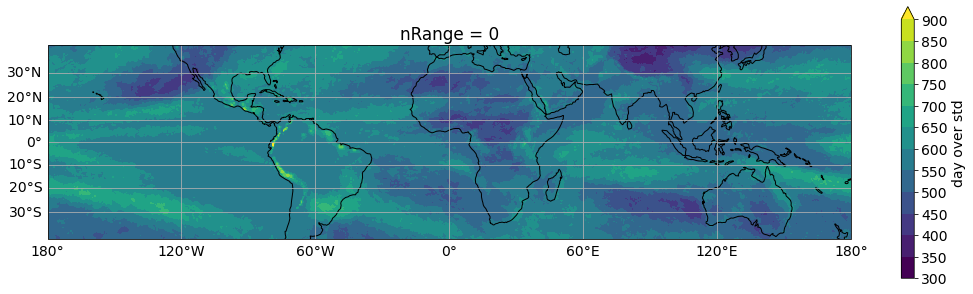

In [15]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

cs = distri_T[0].plot.contourf(transform=ccrs.PlateCarree(),
                               vmin = vmin, vmax = vmax, levels = levels,
                               cbar_kwargs=colorbar
                            )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

# Avec la climatologie sur TOUCAN sans biais

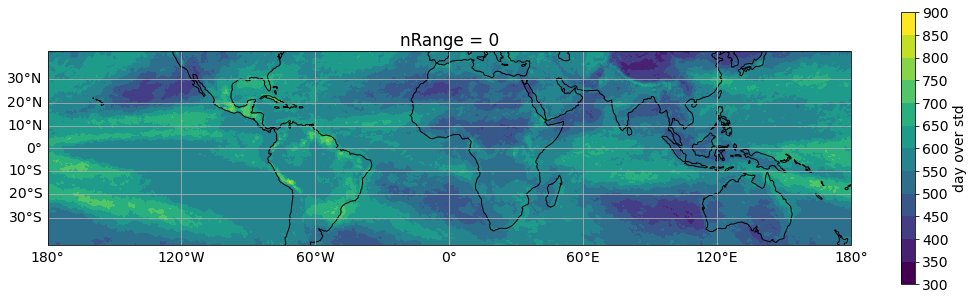

In [16]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

cs = distri_T_WB[0].plot.contourf(transform=ccrs.PlateCarree(),
                                  vmin = vmin, vmax = vmax, levels = levels,
                                  cbar_kwargs=colorbar
                            )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

# Différence entre les deux

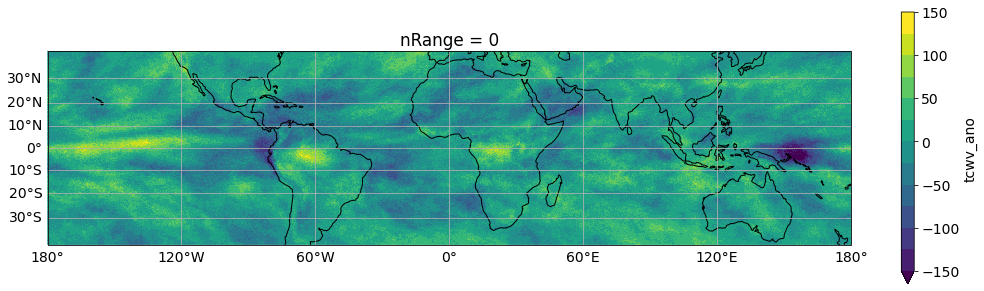

In [22]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

cs = (distri[0] - distri_T_WB[0]).plot(transform=ccrs.PlateCarree(),
                                  levels = levels, vmax = 150, vmin = -150,
                            )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

# En relatif

In [23]:
distri_R = distri/(365*4)+0.01
distri_T_R = distri_T/(365*4)+0.01
distri_T_WB_R = distri_T_WB/(365*4) +0.01

vmin = 0.2
vmax = 0.6

colorbar = {'label': 'day over std',
            'orientation': 'vertical' , 'ticks': np.arange(vmin,vmax+.1,0.1),
            'extend' : 'both'}

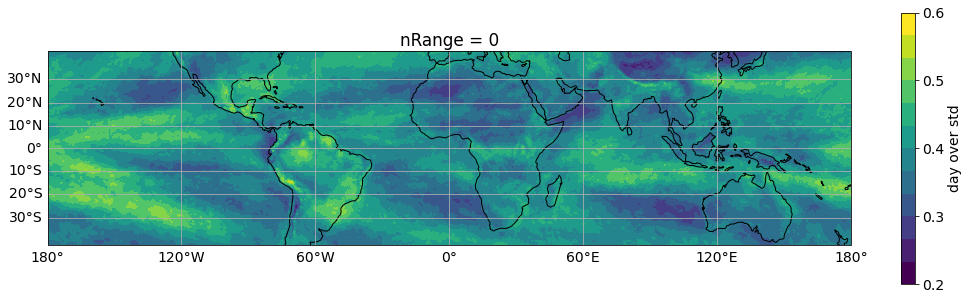

In [24]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

cs = distri_R[0].plot.contourf(transform=ccrs.PlateCarree(),
                                  vmin = vmin, vmax = vmax, levels = levels,
                                  cbar_kwargs=colorbar
                            )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

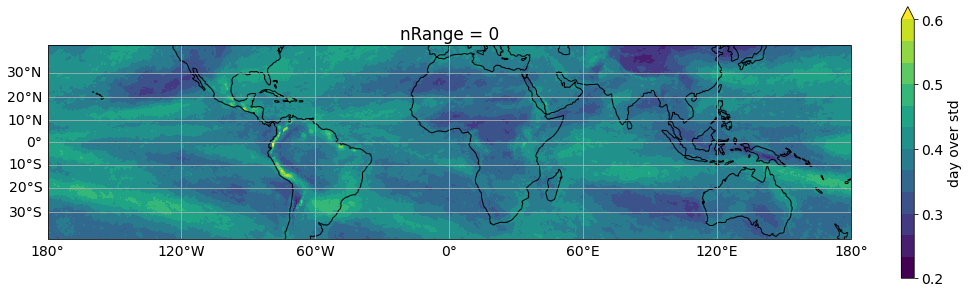

In [19]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

cs = distri_T_R[0].plot.contourf(transform=ccrs.PlateCarree(),
                                  vmin = vmin, vmax = vmax, levels = levels,
                                  cbar_kwargs=colorbar
                            )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

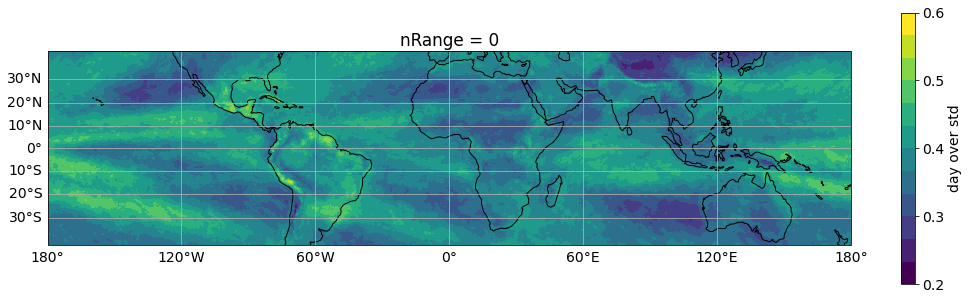

In [20]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

cs = distri_T_WB_R[0].plot.contourf(transform=ccrs.PlateCarree(),
                                  vmin = vmin, vmax = vmax, levels = levels,
                                  cbar_kwargs=colorbar
                            )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

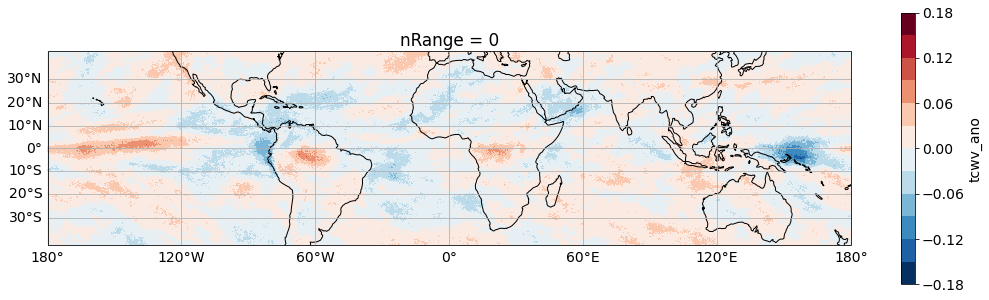

In [26]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

cs = (distri_R[0] - distri_T_WB_R[0]).plot(transform=ccrs.PlateCarree(),
                                  levels = levels
                            )

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

# Correlation

In [12]:
vmax = 1
vmin = 0.9
levels = 101
cmap ='RdBu_r'
size = 5

colorbar = {'label': 'correlation',
            'orientation': 'vertical' , 'ticks': np.arange(vmin,vmax+.1,0.02),
            }

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-40.0, 
                         max_latitude=40.0, 
                         globe=None)

<Figure size 1152x288 with 0 Axes>

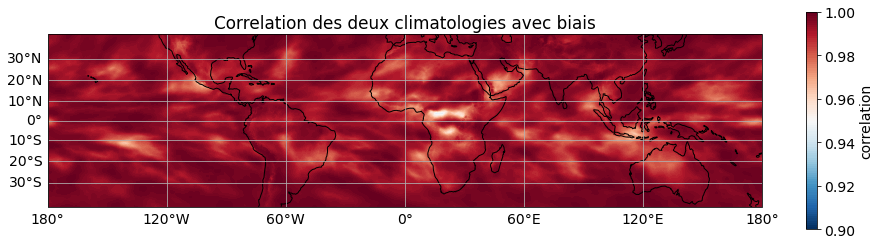

<Figure size 1152x288 with 0 Axes>

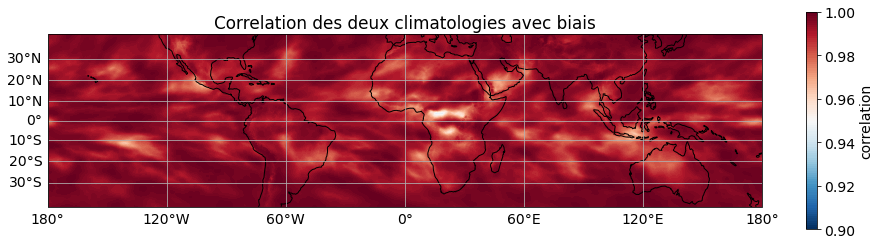

KeyboardInterrupt: 

<Figure size 1152x288 with 0 Axes>

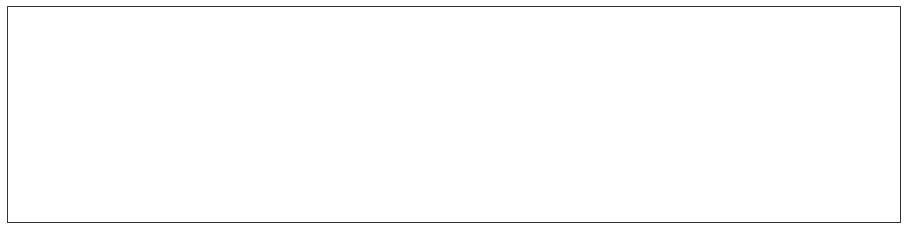

In [14]:
for y in year :

    corr_Clim = xr.corr(ds['tcwv_ano'].sel(time = str(y)), ds_T['tcwv_ano'].sel(time = str(y)), dim = 'time')
    corr_Clim_WB = xr.corr(ds['tcwv_ano'].sel(time = str(y)), ds_T_WB['tcwv_ano'].sel(time = str(y)), dim = 'time')

    plt.figure()
    fig, axis = plt.subplots(
        1, 1, subplot_kw={'projection': map_proj})

    corr_Clim.plot.contourf(ax=axis, levels = 101,
                        transform=ccrs.PlateCarree(),
                        vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                        cbar_kwargs=colorbar)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.title('Correlation des deux climatologies avec biais')
    plt.show()
                           
    plt.figure()
    fig, axis = plt.subplots(
        1, 1, subplot_kw={'projection': map_proj})

    corr_Clim_WB.plot.contourf(ax=axis, levels = 101,
                        transform=ccrs.PlateCarree(),
                        vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                        cbar_kwargs=colorbar)

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.title('Correlation des deux climatologies avec biais')
    plt.show()

In [9]:
corr_Clim = corr_Clim.load()

<Figure size 1152x288 with 0 Axes>

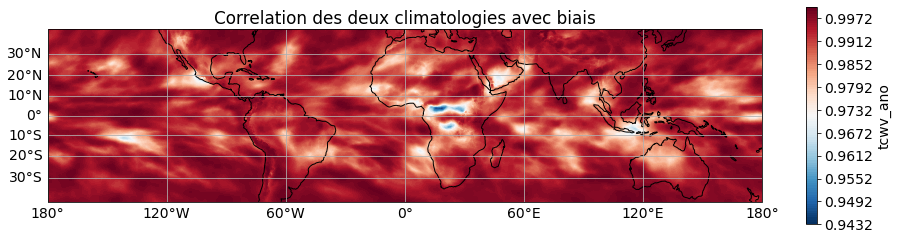

In [11]:
plt.figure()
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

corr_Clim.plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap),# multiplot settings
                    #cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title('Correlation des deux climatologies avec biais')
plt.show()